# Случайность в вероятности и на практике

О подходах к понятию случайности: 

Н.К. Верещагин, В.А. Успенский, А. Шень. Колмогоровская сложность и алгоритмическая случайность. 
https://www.mccme.ru/free-books/shen/kolmbook.pdf

А.Н. Ширяев. Случайность в вероятности (доклад на семинаре кафедры теории веротяностей). http://www.mathnet.ru:8080/PresentFiles/21897/bsk_2018_10_17_shiryaev_an_randomness_in_probability_slides.pdf

## Генераторы случайных чисел

Что происходит при вызове, напрмер, ```np.random.rand()```?

Как устроен источник случайной последовательности?

![img](https://cdn.ablebits.com/_img-blog/random-generator/random-generator.png)

Рассмотрим простой и популрный алгоритм - Linear congruential generator (LCG). При вызове функции ```rand()``` в C/C++ происзодит обращение именно к LCG.

Linear congruential generator производит последовательность:
$$ z_{i+1} = (az_i + c) \mod m $$

Число $z_0$ называется *seed* и обеспечивает воспроизводимость последовательности “случайных” чисел.

Напишем функцию, которая реализует LCG:

In [ ]:
def rng(m=2**32, a=1103515245, c=12345):
    rng.current = (a * rng.current + c) % m
    return rng.current / m

# setting the seed
rng.current = 1

Выведем несколько первых элементов последовательности:

In [ ]:
[rng() for i in range(10)]

Выбор параметров $m$, $a$ и $c$ существенно влияет на качество последовательности. Если параметры выбрать наобум, это может привести к неожиданным последствиям:

In [ ]:
def rng(m=97, a=5, c=0):
    rng.current = (a * rng.current + c) % m
    return rng.current / m
rng.current = 7

random = [rng() for i in range(1000)]
print("This sequence looks as random:")
random[:10]

Гистограмма распределения похожа на равномерное:

In [ ]:
import matplotlib.pyplot as plt
plt.hist(random, normed=True)
plt.show()

Однако, спектральный тест показывает, что точки располагаются на гиперплоскостях, что плохо согласуется с предствалением о случайности:

In [ ]:
plt.scatter(random[1:], random[:-1])
plt.show()

Более аккуратный выбор параметров приводит с более "случайному" распределению:

In [ ]:
def rng(m=2**32, a=1103515245, c=12345):
    rng.current = (a * rng.current + c) % m
    return rng.current / m
rng.current = 1

random = [rng() for i in range(1000)]
plt.scatter(random[1:], random[:-1])
plt.show()

Существует набор тестов для проверки "случайности". Например, тесты [Diehard tests](https://en.wikipedia.org/wiki/Diehard_tests).

Больше методов генерации собрано [здесь](https://en.wikipedia.org/wiki/List_of_random_number_generators).

## Генерация выборки из заданного распределения

Допустим, у нас есть генератор случайных числе из отрезка [0, 1]. Как получить выборку из нового распределения $F$?



### Задача
Смоделировать выборку объема 1000 из дискретного распределения на множестве цифр 0, 1, 2, ..., 9 с весами 0.12, 0.3, 0.167, 0.24, 0.31, 0.54, 0.111, 0.02, 0.001, 0.2. По выборке построить гистограмму. Оптимизируйте алгоритм, упорядочив веса. Сравните время генерации выборки с неупорядоченными и упорядоченными весами.


Time =  0.007992982864379883


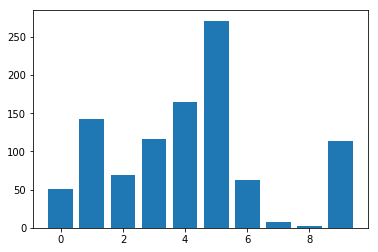

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time

weights = np.array([0.12, 0.3, 0.167, 0.24, 0.31, 0.54, 0.111, 0.02, 0.001, 0.2])

start = time.time()
weights = weights / weights.sum()
s = [weights[:i].sum() for i in range (1,11)]
x = [np.random.rand() for i in range(1000)]
res = []
for i in range (1000):
    for j in range(10):
        if x[i] < s[j]:
            res.append(j)
            break
end = time.time()
print("Time = " , end-start)
plt.bar(np.arange(10), [res.count(i) for i in range(10)])
plt.show()

Time =  0.009996891021728516


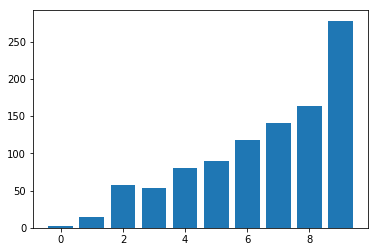

In [18]:
## Упорядочим веса

weights = np.array([0.12, 0.3, 0.167, 0.24, 0.31, 0.54, 0.111, 0.02, 0.001, 0.2])
weights.sort()

start = time.time()
weights = weights / weights.sum()
s = [weights[:i].sum() for i in range (1,11)]
x = [np.random.rand() for i in range(1000)]
res = []
for i in range (1000):
    for j in range(10):
        if x[i] < s[j]:
            res.append(j)
            break
end = time.time()
print("Time = " , end-start)
plt.bar(np.arange(10), [res.count(i) for i in range(10)])
plt.show()

Время меняется совсем незначительно, иногда даже увеличиватся

### Inverse transform method

В следующем предложении заключается идея метода *inverse transform*:

Если $\xi$ имеет равномерное распределение в $[0,1]$, тогда $F^{-1}(\xi)$ распределена по закону $F$. (Для каких $F$ это верно?)

### Задача
Смделируйте выборку размера 1000 из распределения $Exp(\lambda)$. Постройте выборочную гистограмму и точный график плотности распределения.

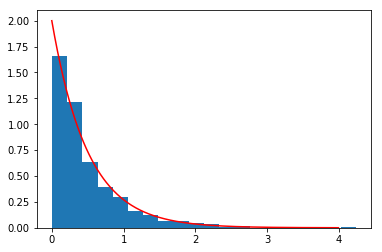

In [19]:
## F(x)=1-e^λx, F^-1(x)=-1/λ*ln(1-x)
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt

a = 2
U = np.random.uniform(size=1000)
X = (-1)* np.log(1 - U) /a
plt.hist(X, density=True, bins=20)

r = np.arange(0, 4, .01)
plt.plot(r, scipy.stats.expon.pdf(r, scale=1 / a), 'r')
plt.show()

### Rejection sampling (Accept-reject method)

Идея метода: сэмплить из распределения, из которого умеем, а затем отбирать точки, которые следуют нужному распределению. Картинка иллюстрирует идею метода:
<img src=https://colcarroll.github.io/hamiltonian_monte_carlo_talk/images/bayes_talk.015.png style="width: 50%;"/>
 

### Задача
Обоснуйте, что метод accept-reject действительно производит выборку из нужного распределения. Смоделируйте 1000 точек из усеченного распределения Коши, приведенного ниже, используя генератор равномерного распределения. Нарисуйте график полученной выборочной гистограммы и сравните его с графиком точной функции плотности.

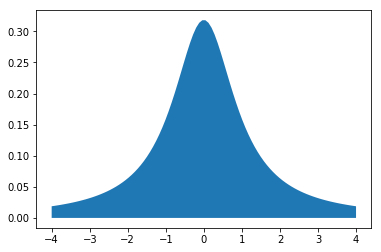

In [20]:
from scipy import stats
import numpy as np
dist = stats.cauchy()
x = np.linspace(-4, 4, 100)
plt.fill_between(x, 0, dist.pdf(x)) #needs to be normalized!
plt.show()

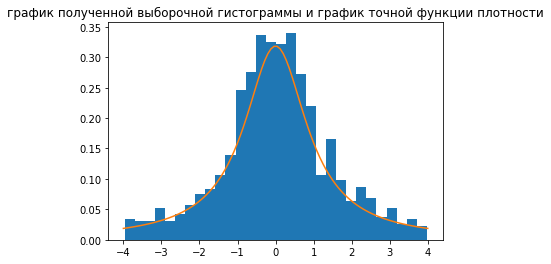

In [21]:
## Метод действительно производит выборку из нужного распределения, т.к мы выбирает точки 
## равномерно из области под графиком f(x), а это и означает что получается выборка из f(x).
dist = stats.cauchy()
x = np.linspace(-4, 4, 100)
res = np.zeros(1000)    
j = 0

while(j != 1000):
    z = 8 * np.random.rand() - 4 
    u = np.random.rand()
    if (u <= dist.pdf(z) / (4 * 1/8)):
        res[j] = z
        j += 1
        
plt.hist(res, bins = 30, density = True)
plt.plot(x, dist.pdf(x))
plt.title("график полученной выборочной гистограммы и график точной функции плотности")
plt.show()

##  Coordinate transformation method

Метод аccept-reject в ряде случаев может оказываться неэффективным и требовать слишком много пробных точек. Альтернатива -  попробовать найти преобразование координат, которое переводит простую область (из которой легко сэмплить, например, едининчный квадрат) в требуемую, но при этом сохраняет соотношение площадей.

### Задача
Смоделировать выборку из 500 точек равномерно распределенных внутри данного треугольника без использования метода отбора. 

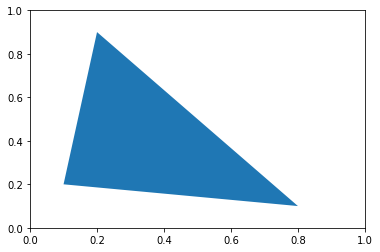

In [22]:
import matplotlib
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

polygon = Polygon(0.1 * np.array([[1, 2], [2, 9], [8, 1]]), True)
plt.gca().add_collection(PatchCollection([polygon]))
plt.show()

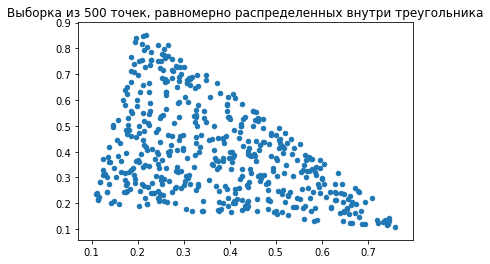

In [23]:
import math

## треугольник прямоугольный, поэтому если оси координат повернуть на арктангенс 1/7 по часовой стрелке 
##и сдвинуть начало координат в точку (0.1 , 0.2), 
##нас будет интересовать треугольник, ниже прямой y=1-x

x_rand = np.array([np.random.rand() for i in range(500)])
y_rand = np.array([np.random.rand() for i in range(500)])

for i in range(500):
    if y_rand[i]> 1-x_rand[i]:
        x_rand[i]= 1-x_rand[i]
        y_rand[i]= 1-y_rand[i]
        
x_rand*=math.hypot(0.7, 0.1)
y_rand*=math.hypot(0.7, 0.1)

angle = np.arctan(-1/7)
x_sample = x_rand * np.cos(angle) - y_rand * np.sin(angle) + 0.1
y_sample =x_rand * np.sin(angle) + y_rand * np.cos(angle) + 0.2

plt.scatter(x_sample, y_sample, s = 20, label = "sample")
plt.title("Выборка из 500 точек, равномерно распределенных внутри треугольника")
plt.show()

### Задача
Смоделировать выборку из 500 точек внутри данного круга без использования метода отбора.

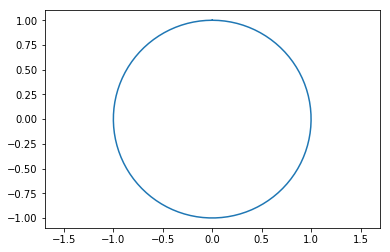

In [24]:
from matplotlib.patches import Circle
t = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.sin(t), np.cos(t))
plt.axis('equal')
plt.show()

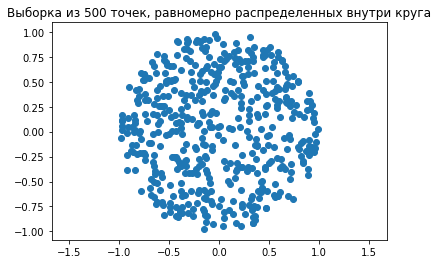

In [25]:
import math

t = np.linspace(0, 2 * np.pi, 100)
angle = 2*math.pi*np.random.rand(1, 500)
rad = np.sqrt(np.random.rand(1, 500))

x_rand = rad*np.cos(angle)
y_rand = rad*np.sin(angle)

plt.scatter(x_rand, y_rand)
plt.axis('equal')
plt.title("Выборка из 500 точек, равномерно распределенных внутри круга")
plt.show()

### Задача
Напишите функцию, которая моделирует случайное симметричное блуждание на двумерной решетке длины n c началом и концом в точке (0, 0). Приведите графики выборочных траекторий для n=100.

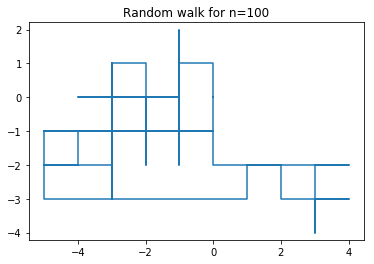

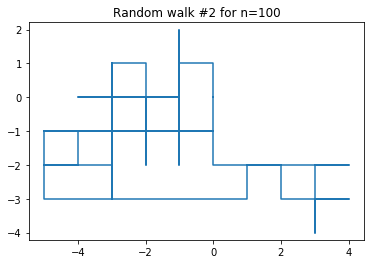

In [26]:
import numpy as np
from matplotlib.patches import Circle

n = 100
ox=np.ones(n)
oy=np.ones(n)
x_min = np.random.choice(np.arange(n), n // 2, False)
y_min = np.random.choice(np.arange(n), n // 2, False)
ox[x_min] = - 1
oy[y_min] = - 1
x_step = (ox + oy) / 2
y_step = (ox - oy) / 2
x = np.zeros(n + 1)
y = np.zeros(n + 1)

for i in range(1, n):
    x[i] = x[i - 1] + x_step[i - 1]
    y[i] = y[i - 1] + y_step[i - 1]
            
plt.plot(x, y)
plt.axis('equal')
plt.title("Random walk for n=100")
plt.show()

plt.plot(x, y)
plt.axis('equal')
plt.title("Random walk #2 for n=100")
plt.show()

## Random normal generator

### Задача
Докажите, что приведенный ниже алгоритм (Box-Muller algorithm) формирует выборку из независимых N(0,1) случаных величин. Модифицируйте метод, чтобы исключить вызовы тригонометрических функций ```np.sin``` и ```np.cos```. С помощью модивицированного метода смоделируйте выборку объема 1000 из двумерного гауссовского распределения со средним (3, 6) и ковариационной матрицей ((2, 1), (1, 4)). Постройте 2D гистограмму полученного распределения.

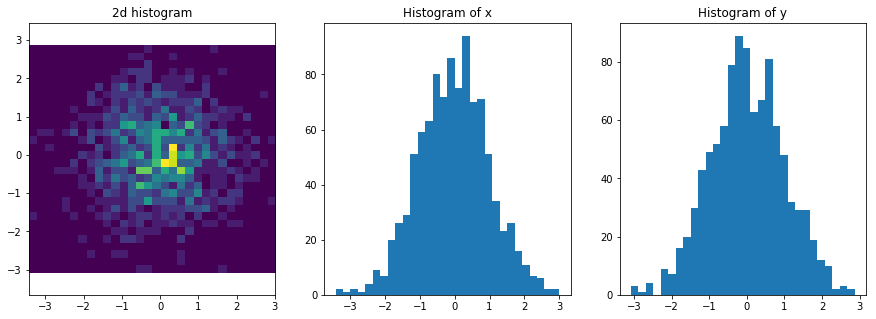

In [27]:
n = 1000
u1, u2 = np.random.rand(2, n)
r = np.sqrt(-2 * np.log(u1))
theta = 2 * np.pi * u2
x = r * np.cos(theta)
y = r * np.sin(theta)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist2d(x, y, bins=30)
ax[0].axis('equal')
ax[1].hist(x, bins=30)
ax[2].hist(y, bins=30)
ax[0].set_title("2d histogram")
ax[1].set_title("Histogram of x")
ax[2].set_title("Histogram of y")
plt.show()

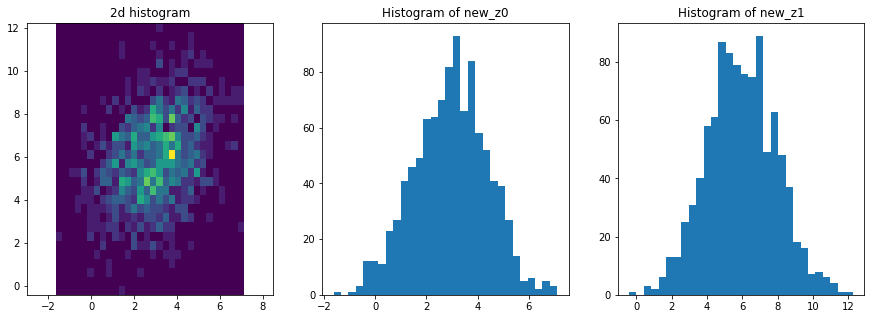

In [28]:
import scipy.stats
import statistics

n = 1000

x_res = np.array([])
y_res = np.array([])
s_res = np.array([])
i=0
while i != n:
    x = np.random.uniform(low=-1, high= 1)
    y = np.random.uniform(low=-1, high= 1)
    s = x**2+ y**2
    if 0<s<=1:
        x_res=np.append(x_res, x)
        y_res=np.append(y_res, y)
        s_res=np.append(s_res, s)
        i+=1
k=np.sqrt(- 2 * np.log(s_res) / s_res) 

z0 = k *x_res
z1 = k *y_res

##ковариационная матрица S преобразуется по закону ASA^t при линейных преобразованиях, где S единичная матрица, т.к z0 z1 независимые, нормальо распределенные
## пусть искомая матрица ((a, b)(c,d)) и d=0. AA^t= ((2, 1)(1,4)) находим a=0.5 b=sqrt(7)/2  c=2
## м.о. также нулевые, поэтому прибавяем вектор (3, 6)

new_z0=z0/2 + np.sqrt(7)*z1/2 +3
new_z1=2*z0 +6

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist2d(new_z0, new_z1, bins=30)
ax[0].axis('equal')
ax[1].hist(new_z0, bins=30)
ax[2].hist(new_z1, bins=30)
ax[0].set_title("2d histogram")
ax[1].set_title("Histogram of new_z0")
ax[2].set_title("Histogram of new_z1")
plt.show()

# Практическое задание
Реализовать метод генерации случайного разбиения n-элементного множества на подмножества. С его помощью оценить ожидаемое число подмножеств в случайном разбиении множества из 100 элементов.

Подсказка 1: Ширяев, Вероятность, т1, задача 2 к параграфу 1.

Подсказка 2: http://djalil.chafai.net/blog/2012/05/03/generating-uniform-random-partitions/


In [31]:
def K_generator(values, prob, n):
    K = np.random.choice(values, None, True, prob) 
    colors = np.zeros(n)
    for i in range(n):
        colors[i] = np.random.randint(1, K + 1)
    return len(np.unique(colors))

def B_generator(n):
    B = np.zeros(n+1)
    B[0]=1
    for i in range(1,n+1):
        sum = 0
        for j in range(i):
            sum += B[j] * math.factorial(i - 1) / (math.factorial(j) * math.factorial(i - 1 - j))
        B[i]=sum
    return B[n]

def P_generator(n):
    weights = np.zeros(n)
    s = 0
    for k in range(1, n + 1):
        weights[k - 1] = pow(k, n) / (math.factorial(k) * np.e * B_generator(n))
        s += weights[k - 1]
    prob=weights/s
    return prob

n = 100
values = 1 + np.arange(n)
prob = P_generator(n)

res = np.array([K_generator(values, prob, n) for i in range(1000)])
print("Ожидаемое число подмножеств = ", res.mean())

Ожидаемое число подмножеств =  28.605
